In [1]:
using LowRankApprox
using Plots
using LinearAlgebra
using Jacobi
using Test

In [2]:
function TrilinearMap(coord_E, xhat, yhat, zhat)
    """
    Input:
    coord_E: coordinate of element E as a 6x3 matrix
    The prism is defined by cutting a cube [-1,1]^3 on diagonal y = -x
    
    Local numbering of Prism
    
        4--------6           z
      / |                    |
    5   |                    |
    |   |                    /----y
    |   |                   /
    |   1 -------3         x
    | /
    2

    """
    
    m = length(xhat)
    N1 = @. 0.25*(-xhat-yhat)*(1-zhat)
    N2 = @. 0.25*(1+xhat)*(1-zhat)
    N3 = @. 0.25*(1+yhat)*(1-zhat)
    N4 = @. 0.25*(-xhat-yhat)*(1+zhat)
    N5 = @. 0.25*(1+xhat)*(1+zhat)
    N6 = @. 0.25*(1+yhat)*(1+zhat)
    N = [N1 N2 N3 N4 N5 N6]
    X = N * coord_E
    # X(3 x m), 1st row x, 2nd row y, 3rd row z
    X = X'
    # gradient of N, [dN/dxhat; dN/dyhat; dN/dzhat]
    GradN = zeros(3,m,6)
    GradN[1,:,:] = @. 0.25*[-(1-zhat) (1-zhat) zeros(m) -(1+zhat) (1+zhat) zeros(m)]
    GradN[2,:,:] = @. 0.25*[-(1-zhat) zeros(m) (1-zhat) -(1+zhat) zeros(m) (1+zhat)]
    GradN[3,:,:] = @. 0.25*[-(-xhat-yhat) -(1+xhat) -(1+yhat) (-xhat-yhat) (1+xhat) (1+yhat)]

    # JT = [[dx/dxhat, dy/dxhat, dz/dxhat],
    #       [dx/dyhat, dy/dyhat, dz/dyhat],
    #       [dx/dzhat, dy/dzhat, dz/dzhat]] (3m x 3)

    JTxhat = GradN[1,:,:] * coord_E
    dxdxhat = JTxhat[:,1]
    dydxhat = JTxhat[:,2]
    dzdxhat = JTxhat[:,3]
    JTyhat = GradN[2,:,:] * coord_E
    dxdyhat = JTyhat[:,1]
    dydyhat = JTyhat[:,2]
    dzdyhat = JTyhat[:,3]
    JTzhat = GradN[3,:,:] * coord_E
    dxdzhat = JTzhat[:,1]
    dydzhat = JTzhat[:,2]
    dzdzhat = JTzhat[:,3]
    # compute det
    j1 = @. (dxdxhat*dydyhat*dzdzhat + dxdyhat*dydzhat*dzdzhat + dxdzhat*dydxhat*dzdyhat)
    j2 = @. (dxdxhat*dydzhat*dzdyhat + dxdyhat*dydxhat*dzdzhat + dxdzhat*dydyhat*dzdxhat)
    detJ = @. j1 - j2
    
    J = zeros(3,m,3)
    J[1,:,:] = [dxdxhat dxdyhat dxdzhat]
    J[2,:,:] = [dydxhat dydyhat dydzhat]
    J[3,:,:] = [dzdxhat dzdyhat dzdzhat]
    
    return X, J, detJ
end

TrilinearMap (generic function with 1 method)

In [3]:
function PrimeBasis(coord_E, xhat, yhat, zhat)

    m = length(xhat)
    # supplements from Wheeler, Xue, & Yotov, 2012
    # I eliminate two vectors as Nate did
    shat1 = [(xhat .* zhat) (-yhat .* zhat) (zeros(m))]
    shat2 = [(zeros(m)) (-2*xhat .* zhat) (zeros(m))]  
    shat3 = [(zeros(m)) (xhat .* yhat) (-xhat .* zhat)]
    shat4 = [(zeros(m)) (2*yhat .* zhat) (-zhat.^2)]
    shat5 = [(zeros(m)) (zeros(m)) (-2*xhat .* yhat)]
    shat6 = [(zeros(m)) (xhat .* yhat.^2) (-2*xhat .* yhat .* zhat)]
    shat7 = [(-xhat .* yhat) (zeros(m)) (yhat .* zhat)]
    shat8 = [(-xhat.^2) (zeros(m)) (2*xhat .* zhat)]
    shat9 = [(-2*yhat .* zhat) (zeros(m)) (zeros(m))]
    shat10 = [(-2*xhat .* yhat .* zhat) (zeros(m)) (yhat .* zhat.^2)]
    # X are in E
    X, J, detJ = TrilinearMap(coord_E, xhat, yhat, zhat)
    x = X[1,:]
    y = X[2,:]
    z = X[3,:]
    # Prime basis in 3D space with dimension 22
    P = zeros(3,m,22)
    P[1,:,1] = ones(m)
    P[1,:,2] = x
    P[1,:,3] = y
    P[1,:,4] = z
    P[2,:,5] = ones(m)
    P[2,:,6] = x
    P[2,:,7] = y
    P[2,:,8] = z
    P[3,:,9] = ones(m)
    P[3,:,10] = x
    P[3,:,11] = y
    P[3,:,12] = z
    # supplement
    P[1,:,13] = (J[1,:,1] .* shat1[:,1] + J[1,:,2] .* shat1[:,2] + J[1,:,3] .* shat1[:,3]) ./ detJ
    P[2,:,13] = (J[2,:,1] .* shat1[:,1] + J[2,:,2] .* shat1[:,2] + J[2,:,3] .* shat1[:,3]) ./ detJ
    P[3,:,13] = (J[3,:,1] .* shat1[:,1] + J[3,:,2] .* shat1[:,2] + J[3,:,3] .* shat1[:,3]) ./ detJ

    P[1,:,14] = (J[1,:,1] .* shat2[:,1] + J[1,:,2] .* shat2[:,2] + J[1,:,3] .* shat2[:,3]) ./ detJ
    P[2,:,14] = (J[2,:,1] .* shat2[:,1] + J[2,:,2] .* shat2[:,2] + J[2,:,3] .* shat2[:,3]) ./ detJ
    P[3,:,14] = (J[3,:,1] .* shat2[:,1] + J[3,:,2] .* shat2[:,2] + J[3,:,3] .* shat2[:,3]) ./ detJ

    P[1,:,15] = (J[1,:,1] .* shat3[:,1] + J[1,:,2] .* shat3[:,2] + J[1,:,3] .* shat3[:,3]) ./ detJ
    P[2,:,15] = (J[2,:,1] .* shat3[:,1] + J[2,:,2] .* shat3[:,2] + J[2,:,3] .* shat3[:,3]) ./ detJ
    P[3,:,15] = (J[3,:,1] .* shat3[:,1] + J[3,:,2] .* shat3[:,2] + J[3,:,3] .* shat3[:,3]) ./ detJ

    P[1,:,16] = (J[1,:,1] .* shat4[:,1] + J[1,:,2] .* shat4[:,2] + J[1,:,3] .* shat4[:,3]) ./ detJ
    P[2,:,16] = (J[2,:,1] .* shat4[:,1] + J[2,:,2] .* shat4[:,2] + J[2,:,3] .* shat4[:,3]) ./ detJ
    P[3,:,16] = (J[3,:,1] .* shat4[:,1] + J[3,:,2] .* shat4[:,2] + J[3,:,3] .* shat4[:,3]) ./ detJ

    P[1,:,17] = (J[1,:,1] .* shat5[:,1] + J[1,:,2] .* shat5[:,2] + J[1,:,3] .* shat5[:,3]) ./ detJ
    P[2,:,17] = (J[2,:,1] .* shat5[:,1] + J[2,:,2] .* shat5[:,2] + J[2,:,3] .* shat5[:,3]) ./ detJ
    P[3,:,17] = (J[3,:,1] .* shat5[:,1] + J[3,:,2] .* shat5[:,2] + J[3,:,3] .* shat5[:,3]) ./ detJ

    P[1,:,18] = (J[1,:,1] .* shat6[:,1] + J[1,:,2] .* shat6[:,2] + J[1,:,3] .* shat6[:,3]) ./ detJ
    P[2,:,18] = (J[2,:,1] .* shat6[:,1] + J[2,:,2] .* shat6[:,2] + J[2,:,3] .* shat6[:,3]) ./ detJ
    P[3,:,18] = (J[3,:,1] .* shat6[:,1] + J[3,:,2] .* shat6[:,2] + J[3,:,3] .* shat6[:,3]) ./ detJ

    P[1,:,19] = (J[1,:,1] .* shat7[:,1] + J[1,:,2] .* shat7[:,2] + J[1,:,3] .* shat7[:,3]) ./ detJ
    P[2,:,19] = (J[2,:,1] .* shat7[:,1] + J[2,:,2] .* shat7[:,2] + J[2,:,3] .* shat7[:,3]) ./ detJ
    P[3,:,19] = (J[3,:,1] .* shat7[:,1] + J[3,:,2] .* shat7[:,2] + J[3,:,3] .* shat7[:,3]) ./ detJ

    P[1,:,20] = (J[1,:,1] .* shat8[:,1] + J[1,:,2] .* shat8[:,2] + J[1,:,3] .* shat8[:,3]) ./ detJ
    P[2,:,20] = (J[2,:,1] .* shat8[:,1] + J[2,:,2] .* shat8[:,2] + J[2,:,3] .* shat8[:,3]) ./ detJ
    P[3,:,20] = (J[3,:,1] .* shat8[:,1] + J[3,:,2] .* shat8[:,2] + J[3,:,3] .* shat8[:,3]) ./ detJ

    P[1,:,21] = (J[1,:,1] .* shat9[:,1] + J[1,:,2] .* shat9[:,2] + J[1,:,3] .* shat9[:,3]) ./ detJ
    P[2,:,21] = (J[2,:,1] .* shat9[:,1] + J[2,:,2] .* shat9[:,2] + J[2,:,3] .* shat9[:,3]) ./ detJ
    P[3,:,21] = (J[3,:,1] .* shat9[:,1] + J[3,:,2] .* shat9[:,2] + J[3,:,3] .* shat9[:,3]) ./ detJ

    P[1,:,22] = (J[1,:,1] .* shat10[:,1] + J[1,:,2] .* shat10[:,2] + J[1,:,3] .* shat10[:,3]) ./ detJ
    P[2,:,22] = (J[2,:,1] .* shat10[:,1] + J[2,:,2] .* shat10[:,2] + J[2,:,3] .* shat10[:,3]) ./ detJ
    P[3,:,22] = (J[3,:,1] .* shat10[:,1] + J[3,:,2] .* shat10[:,2] + J[3,:,3] .* shat10[:,3]) ./ detJ
    
    return P
end

PrimeBasis (generic function with 1 method)

In [4]:
function GetNormal(coord_E, xhat, yhat, zhat, face)

    X, J, detJ = TrilinearMap(coord_E, xhat, yhat, zhat)

    dxdxhat = J[1,:,1]
    dxdyhat = J[1,:,2]
    dxdzhat = J[1,:,3]
    
    dydxhat = J[2,:,1]
    dydyhat = J[2,:,2]
    dydzhat = J[2,:,3]
    
    dzdxhat = J[3,:,1]
    dzdyhat = J[3,:,2]
    dzdzhat = J[3,:,3]

    m = length(xhat)
    
    if face == "left"
        
        n1 = @. dydxhat*dzdzhat - dzdxhat*dydzhat
        n2 = @. dzdxhat*dxdzhat - dxdxhat*dzdzhat
        n3 = @. dxdxhat*dydzhat - dydxhat*dxdzhat
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
      
    elseif face == "back"
        
        n1 = @. dzdyhat*dydzhat - dydyhat*dzdzhat 
        n2 = @. dxdyhat*dzdzhat - dzdyhat*dxdzhat
        n3 = @. dydyhat*dxdzhat - dxdyhat*dydzhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    
    elseif face == "diagonal"
        #dxdshat = -dxdxhat + dxdyhat, ...
        dxdshat = J[1,:,2] - J[1,:,1]
        dydshat = J[2,:,2] - J[2,:,1]
        dzdshat = J[3,:,2] - J[3,:,1]
        
        n1 = @. dydshat*dzdzhat - dzdshat*dydzhat
        n2 = @. dzdshat*dxdzhat - dxdshat*dzdzhat
        n3 = @. dxdshat*dydzhat - dydshat*dxdzhat
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    
    elseif face == "top"
        
        n1 = @. dydxhat*dzdyhat - dzdxhat*dydyhat 
        n2 = @. dzdxhat*dxdyhat - dxdxhat*dzdyhat 
        n3 = @. dxdxhat*dydyhat - dydxhat*dxdyhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    
    elseif face == "bottom"
        
        n1 = @. dzdxhat*dydyhat - dydxhat*dzdyhat
        n2 = @. dxdxhat*dzdyhat - dzdxhat*dxdyhat
        n3 = @. dydxhat*dxdyhat - dxdxhat*dydyhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    else
        error("face is not defined")
    end

    return n, leng
end

GetNormal (generic function with 1 method)

In [5]:
function PlotElem(coord_E)
    
    x = coord_E[:,1]
    y = coord_E[:,2]
    z = coord_E[:,3]
    nodes = [1 2 3 1 4 5 6 4]
    n = length(nodes)
    xx = zeros(n,1)
    yy = zeros(n,1)
    zz = zeros(n,1)
    for j =1:n
        xx[j] = x[nodes[j]] 
        yy[j] = y[nodes[j]] 
        zz[j] = z[nodes[j]]
    end
    plot(xx,yy,zz,color="black",legend=false)
    xx2 = zeros(2,1)
    yy2 = zeros(2,1)
    zz2 = zeros(2,1)
    xx2[1] = x[2]; xx2[2] = x[5]
    yy2[1] = y[2]; yy2[2] = y[5]
    zz2[1] = z[2]; zz2[2] = z[5]
    
    xx3 = zeros(2,1)
    yy3 = zeros(2,1)
    zz3 = zeros(2,1)
    xx3[1] = x[3]; xx3[2] = x[6]
    yy3[1] = y[3]; yy3[2] = y[6]
    zz3[1] = z[3]; zz3[2] = z[6]
    
    plot!(xx2,yy2,zz2,color="black",legend=false)
    p2 = plot!(xx3,yy3,zz3,color="black",legend=false, title = "3D view")
    
    # to see from top 
    # bottom face
    nodes = [1 2 3 1]
    n = length(nodes)
    xb = zeros(n,1)
    yb = zeros(n,1)
    for j =1:n
        xb[j] = x[nodes[j]] 
        yb[j] = y[nodes[j]] 
    end
    # top face
    nodes = [4 5 6 4]
    n = length(nodes)
    xt = zeros(n,1)
    yt = zeros(n,1)
    for j =1:n
        xt[j] = x[nodes[j]] 
        yt[j] = y[nodes[j]] 
    end
    plot(xb,yb,color="black",legend=false)
    pp=plot!(xt,yt,color="black",legend=false, title = "Top View")
    
    plot(p2,pp)
    
end

PlotElem (generic function with 1 method)

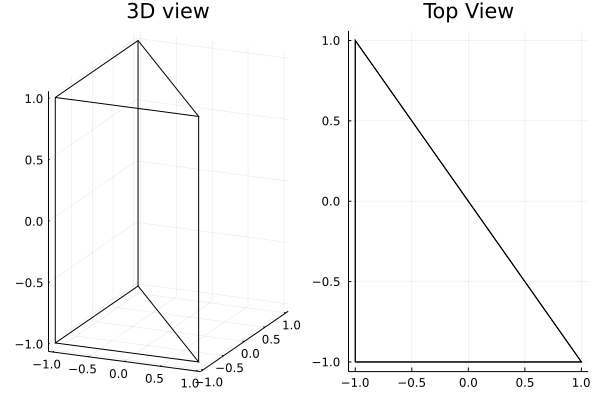

In [6]:
# unstructured element
#coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1]
# reference element
coord_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.]
PlotElem(coord_E)

# Test Normal

In [7]:
@testset "TestNormal" begin
    
    # unstructured element
    # coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1.]
    # reference element
    coord_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.]
    
    nl, le = GetNormal(coord_E, [0.], [-1.],[0.],"left")
    nd, le = GetNormal(coord_E, [0.], [0.],[0.],"diagonal")
    nbt, le = GetNormal(coord_E, [-0.5], [-0.5],[-1.],"bottom")
    nt, le = GetNormal(coord_E, [-0.5], [-0.5],[1.],"top")
    nbk, le = GetNormal(coord_E, [-1.], [0.],[0.],"back")

    # check the left face normal
    a = coord_E[2,:] - coord_E[1,:] 
    b = coord_E[4,:] - coord_E[1,:]
    c = cross(a,b)
    c = normalize(c)
    @test nl[:] == c[:]

    # check the back face normal 
    a = coord_E[4,:] - coord_E[1,:]
    b = coord_E[3,:] - coord_E[1,:]
    c = cross(a,b)
    c = normalize(c)
    @test nbk[:] == c[:]
    
    # check the diagonal face normal 
    a = coord_E[3,:] - coord_E[2,:]
    b = coord_E[5,:] - coord_E[2,:]
    c = cross(a,b)
    c = normalize(c)
    @test nd[:] == c[:]
    
    # check the top face normal 
    a = coord_E[5,:] - coord_E[4,:]
    b = coord_E[6,:] - coord_E[4,:]
    c = cross(a,b)
    c = normalize(c)
    @test nt[:] == c[:]
    
    # check the bottom face normal 
    a = coord_E[3,:] - coord_E[1,:]
    b = coord_E[2,:] - coord_E[1,:]
    c = cross(a,b)
    c = normalize(c)
    @test nbt[:] == c[:]
    
end

Test Summary: | Pass  Total
TestNormal    |    5      5


Test.DefaultTestSet("TestNormal", Any[], 5, false, false)

In [8]:
include("GetQuadratureTriangle.jl") # returns w, q for integration over triangle (-1,-1), (1,-1), (-1,1)

function GetQuadrature2D(Q)
    """
    Gauss Quadrature over [-1,1]^2
    Q: Number of Gauss points in 1D
    
    """
    # 1D Gauss
    alpha = 0.0
    beta = 0.0
    q = zgj(Q, alpha, beta)
    w = wgj(q, alpha, beta)
    
    w2 = zeros(Q*Q)
    qx = zeros(Q*Q)
    qy = zeros(Q*Q)
    for i=1:Q
        for j=1:Q
            k = (i-1)*Q +j
            qx[k] = q[j]
            qy[k] = q[i]
            w2[k] = w[j]*w[i]
        end
    end
    return w2, qx, qy
end

function Legendre2D(x,y,i,j)
    # Legendre2D define on [-1,1]^2
    return legendre(x,i) .* legendre(y,j)
end

function Dubiner(x,y,i,j)
    # Dubiner polynomial defined on triangle (-1,-1),(1,-1),(-1,1)
    eta1 = 2*(1 .+ x) ./ clamp.(1 .- y,1e-12,10) .- 1
    eta2 = y
    D    = jacobi.(eta1, i, 0, 0)
    D   *= (0.5*(1 .- eta2)) .^i
    D   *= jacobi.(eta2, j, 2*i+1, 0)
    return D
end

Dubiner (generic function with 1 method)

# Test Integration

In [9]:
@testset "TestIntegration" begin

    # unstructured element
     coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1.]
    # reference element
    #coord_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.]
   
    # get quadrature on [-1,1]^2
    Q1d_quad = 5 # No. pts in 1D
    ww, q1, q2 = GetQuadrature2D(Q1d_quad)
    m1 = -ones(Q1d_quad*Q1d_quad)
    p1 = ones(Q1d_quad*Q1d_quad)
    
    # left face    
    n, le = GetNormal(coord_E, q1, m1, q2, "left")
    Integral = (ww .* le)' *(Legendre2D.(q1,q2,2,0) .* Legendre2D.(q1,q2,1,2))
    @test isapprox(Integral, 0.;atol=1e-15)
    
    # back face
    n, le = GetNormal(coord_E, m1, q1, q2, "back")
    Integral = (ww .* le)' *(Legendre2D.(q1,q2,2,0) .* Legendre2D.(q1,q2,1,2))
    @test isapprox(Integral, 0.;atol=1e-15)
    
    # diagonal face
    n, le = GetNormal(coord_E, -q1, q1, q2, "diagonal")
    Integral = (ww .* le)' *(Legendre2D.(q1,q2,2,0) .* Legendre2D.(q1,q2,1,2))
    @test isapprox(Integral, 0.;atol=1e-15)
    
    # get quadrature on (-1,-1), (1,-1), (-1,1)
    Q_tri = 16 # No. pts in 2D
    ww, q = GetQuadratureTriangle(Q_tri)
    q1 = q[:,1]
    q2 = q[:,2]
    m1 = -ones(Q_tri)
    p1 = ones(Q_tri)
    
    # top face
    n, le = GetNormal(coord_E, q1, q2, p1, "top")
    Integral = (ww .* le)' *(Dubiner.(q1,q2,1,2) .* Dubiner.(q1,q2,2,2))
    @test isapprox(Integral, 0.;atol=1e-15)
    
    # bottom face
    n, le = GetNormal(coord_E, q1, q2, m1, "bottom")
    Integral = (ww .* le)' *(Dubiner.(q1,q2,2,1) .* Dubiner.(q1,q2,2,2))
    @test isapprox(Integral, 0.;atol=1e-15)
end

Test Summary:   | Pass  Total
TestIntegration |    5      5


Test.DefaultTestSet("TestIntegration", Any[], 5, false, false)

In [21]:
function IntegrateFace(i,j,coord_E, face, Q1d_quad, Q_tri)
    """
    Input:
    i,j: degrees of Legendre polynomials L_i(s)L_j(t)
    coord_E: physical coordinate of element E
    face: face that you want to compute the normal component of the trace
    Q1d_quad: No. pts in 1D for integration over quad faces
    Q_tri: No. pts in 2D for integration over triangle faces
    
    Return:
    this function returns int{P.n * L_i(s)L_j(t)}dA
    where "n" is the normal on the physical face
    "L" are Legendre polynomial

    local numbering of Prism
    
        4--------6           z
      / |                    |
    5   |                    |
    |   |                    /----y
    |   |                   /
    |   1 -------3         x
    | /
    2

    """
    # get quadrature on [-1,1]^2
    ww, q1, q2 = GetQuadrature2D(Q1d_quad)
    m1 = -ones(Q1d_quad*Q1d_quad)
    p1 = ones(Q1d_quad*Q1d_quad)
    
    # get quadrature on triangle (-1,-1), (1,-1), (-1,1)
    wwt, qt = GetQuadratureTriangle(Q_tri)
    q1t = qt[:,1]
    q2t = qt[:,2]
    m1t = -ones(Q_tri)
    p1t = ones(Q_tri)
    
    # left face includes nodes 1,2,4,5 at yhat = -1
    if face == "left"
        n, le = GetNormal(coord_E, q1, m1, q2, face)
        P = PrimeBasis(coord_E, q1, m1, q2)
        PdotN = P[1,:,:] .* n[1,:] + P[2,:,:] .* n[2,:] + P[3,:,:] .* n[3,:]
        trace = PdotN' *(ww .* le .* Legendre2D.(q1, q2,i,j))
        
    # back face includes nodes 1,3,4,6 at xhat = -1
    elseif face == "back"
        n, le = GetNormal(coord_E, m1, q1, q2, face)
        P = PrimeBasis(coord_E, m1, q1, q2)
        PdotN = P[1,:,:] .* n[1,:] + P[2,:,:] .* n[2,:] + P[3,:,:] .* n[3,:]
        trace = PdotN' *(ww .* le .* Legendre2D.(q1, q2,i,j))
        
    # diagonal face includes nodes 2,3,5,6 at xhat = -yhat
    elseif face == "diagonal"
        n, le = GetNormal(coord_E, -q1, q1, q2, face)
        P = PrimeBasis(coord_E, -q1, q1, q2)
        PdotN = P[1,:,:] .* n[1,:] + P[2,:,:] .* n[2,:] + P[3,:,:] .* n[3,:]
        trace = PdotN' *(ww .* le .* Legendre2D.(q1, q2,i,j))  
        
    # top face includes nodes 4,5,6 at zhat = 1
    elseif face == "top"
        n, le = GetNormal(coord_E, q1t, q2t, p1t, face)
        P = PrimeBasis(coord_E, q1t, q2t, p1t);
        PdotN = P[1,:,:] .* n[1,:] + P[2,:,:] .* n[2,:] + P[3,:,:] .* n[3,:]
        trace = PdotN' *(wwt .* le .* Dubiner.(q1t, q2t,i,j))
        
    # bottom face includes nodes 1,2,3 at zhat = -1
    elseif face == "bottom"
        n, le = GetNormal(coord_E, q1t, q2t, m1t, face)
        P = PrimeBasis(coord_E, q1t, q2t, m1t);
        PdotN = P[1,:,:] .* n[1,:] + P[2,:,:] .* n[2,:] + P[3,:,:] .* n[3,:]
        trace = PdotN' *(wwt .* le .* Dubiner.(q1t, q2t,i,j))
    else
        error("face is not defined")
    end
    
    return trace
    
end

IntegrateFace (generic function with 1 method)

In [22]:
function ConstraintMat(coord_E, Q1d_quad, Q_tri)
    """
    Input:
    coord_E: physical coordinate of element E
    Q1d_quad: No. pts in 1D for integration over quad faces
    Q_tri: No. pts in 2D for integration over triangle faces
    
    Return:
    CM: Constraint Matrix
    """
    
    # On each quad face we compute trace_i,j
    # for (i,j) = (2,0),(2,1),(2,2),(1,2),(0,2) ==> 15 rows for all quad
    # On triangle face we have above (i,j)+(1,1) ==> 12 rows for all tri
    n = [2 2 2 1 0]
    quad = ["left","back","diagonal"]
    # 15 constraint, 22 dim
    L1 = zeros(15,22)
    for i = 1:3 # loop over faces
        for j = 1:length(n) # loop over legendre_i,j
            trace = IntegrateFace(n[j], n[length(n)+1-j], coord_E, quad[i], Q1d_quad, Q_tri)
            L1[j + length(n)*(i-1),:] = trace
        end
    end
    
    L2 = zeros(6,22)
    for j = 1:length(n) # loop over legendre_i,j
        trace = IntegrateFace(n[j], n[length(n)+1-j], coord_E, "top", Q1d_quad, Q_tri)
        L2[j,:] = trace
    end
    L2[6,:] = IntegrateFace(1, 1, coord_E, "top", Q1d_quad, Q_tri)

    L3 = zeros(6,22)
    for j = 1:length(n) # loop over legendre_i,j
        trace = IntegrateFace(n[j], n[length(n)+1-j], coord_E, "bottom", Q1d_quad, Q_tri)
        L2[j,:] = trace
    end
    L3[6,:] = IntegrateFace(1, 1, coord_E, "bottom", Q1d_quad, Q_tri)
    
    L = zeros(27,22)
    L[1:15,:] = L1
    L[16:21,:] = L2
    L[22:27,:] = L3
    return L
end

ConstraintMat (generic function with 1 method)

In [23]:
# unstructured element
#coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1.]
# reference element
coord_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.]
Q1d_quad = 7
Q_tri = 19
L = ConstraintMat(coord_E, Q1d_quad, Q_tri)
F=pqrfact(L')
#Q = F[:Q]
R1 = F[:R]

6×27 UpperTrapezoidal{Float64}:
 -0.92376  -2.33693e-18  -8.33284e-16  …  0.0  0.0  0.0  0.0  0.0
  0.0       0.355556     -4.57967e-16     0.0  0.0  0.0  0.0  0.0
  0.0       0.0          -0.377124        0.0  0.0  0.0  0.0  0.0
  0.0       0.0           0.0             0.0  0.0  0.0  0.0  0.0
  0.0       0.0           0.0             0.0  0.0  0.0  0.0  0.0
  0.0       0.0           0.0          …  0.0  0.0  0.0  0.0  0.0

In [24]:
function clip(x; threshold=1e-15)
    y = copy(x)
    y[abs.(y) .< threshold] .= 0
    y
end

clip (generic function with 1 method)

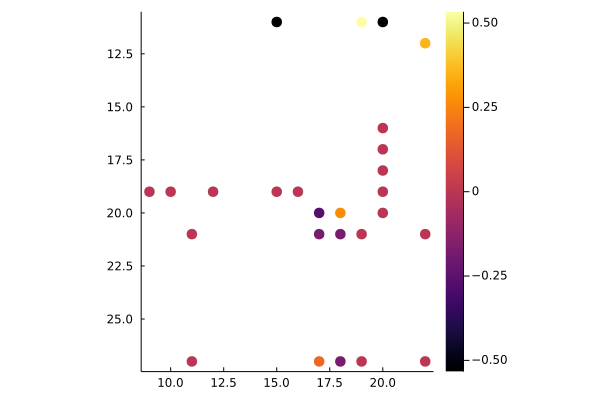

In [25]:
L1 = clip(L)
spy(L1, markersize = 6)

In [52]:
function GetNull(L, mode)
    
    if mode == "QR"
        F=pqrfact(L')
        Qfull, _ = qr(F[:Q])
        VL = Qfull[:, 5:end]
        
    elseif mode == "SVD"
        
        U, S, V = svd(L,full=true)
        VL = V[:,5:end]
    else
        error("mode should be QR or SVD")
    end
    return VL
end

GetNull (generic function with 2 methods)

In [53]:
function GetNodalBasis(coord_E, xhat, yhat, zhat, VL)

    nl, le = GetNormal(coord_E, [0.], [-1.],[0.],"left")
    nd, le = GetNormal(coord_E, [0.], [0.],[0.],"diagonal")
    nbt, le = GetNormal(coord_E, [-0.5], [-0.5],[-1.],"bottom")
    nt, le = GetNormal(coord_E, [-0.5], [-0.5],[1.],"top")
    nbk, le = GetNormal(coord_E, [-1.], [0.],[0.],"back")
    normals = [nbk nl nbt nd nl nbt nbk nd nbt nbk nl nt nd nl nt nbk nd nt]
    nd1 = [0.;0.;-1.]
    nd2 = [1.;0.;-1.]
    nd3 = [0.;1.;-1.]
    nd4 = [0.;0.;1.]
    nd5 = [1.;0.;1.]
    nd6 = [0.;1.;1.]
    nodes = [nd1 nd1 nd1 nd2 nd2 nd2 nd3 nd3 nd3 nd4 nd4 nd4 nd5 nd5 nd5 nd6 nd6 nd6]
    # vondermonde matrix, V_ij = phi_j(x_i).n_i
    VM = zeros(18,18)
    for i=1:18
        for j=1:18
            # original prime basis with dim=22
            P = PrimeBasis(coord_E, nodes[1,i], nodes[2,i], nodes[3,i])
            # reduced prime basis with dim=18
            PP = zeros(3,1,18)
            PP[1,:,:] = P[1,:,:] * VL
            PP[2,:,:] = P[2,:,:] * VL
            PP[3,:,:] = P[3,:,:] * VL
            VM[i,j] = PP[1,1,j] * normals[1,i] + PP[2,1,j] * normals[2,i] + PP[3,1,j] * normals[3,i]
        end
    end
    
    # create nodal basis from vondermonde (VM) and VL
    P = PrimeBasis(coord_E, xhat, yhat, zhat)
    invVM = inv(VM)
    # nodal basis
    m = length(xhat)
    Nhat = zeros(3,m,18)
    Nhat[1,:,:] = P[1,:,:] * VL * invVM
    Nhat[2,:,:] = P[2,:,:] * VL * invVM
    Nhat[3,:,:] = P[3,:,:] * VL * invVM
    return Nhat
end

GetNodalBasis (generic function with 1 method)

In [55]:
function IntegrateNormalTrace(i,j,coord_E, face, Q1d_quad, Q_tri)
    """
    Input:
    i,j: degrees of Legendre polynomials L_i(s)L_j(t)
    coord_E: physical coordinate of element E
    face: face that you want to compute the normal component of the trace
    Q1d_quad: No. pts in 1D for integration over quad faces
    Q_tri: No. pts in 2D for integration over triangle faces
    
    Return:
    this function returns int{N.n * L_i(s)L_j(t)}dA
    where "n" is the normal on the physical face
    "L" are Legendre polynomial, N is nodal basis

    local numbering of Prism
    
        4--------6           z
      / |                    |
    5   |                    |
    |   |                    /----y
    |   |                   /
    |   1 -------3         x
    | /
    2

    """
    # get quadrature on [-1,1]^2
    ww, q1, q2 = GetQuadrature2D(Q1d_quad)
    m1 = -ones(Q1d_quad*Q1d_quad)
    p1 = ones(Q1d_quad*Q1d_quad)
    
    # get quadrature on (-1,-1), (1,-1), (-1,1)
    wwt, qt = GetQuadratureTriangle(Q_tri)
    q1t = qt[:,1]
    q2t = qt[:,2]
    m1t = -ones(Q_tri)
    p1t = ones(Q_tri)
    
    L = ConstraintMat(coord_E, Q1d_quad, Q_tri)
    VL = GetNull(L, "QR")
    
    # left face includes nodes 1,2,4,5 at yhat = -1
    if face == "left"
        n, le = GetNormal(coord_E, q1, m1, q2, "left")
        N = GetNodalBasis(coord_E, q1, m1, q2, VL)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(ww .* le .* Legendre2D.(q1,q2,i,j))
        
    # back face includes nodes 1,3,4,6 at xhat = -1
    elseif face == "back"
        n, le = GetNormal(coord_E, m1, q1, q2, "back")
        N = GetNodalBasis(coord_E, m1, q1, q2, VL)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(ww .* le .* Legendre2D.(q1,q2,i,j))
        
    # diagonal face includes nodes 2,3,5,6 at xhat = -yhat
    elseif face == "diagonal"
        n, le = GetNormal(coord_E, -q1, q1, q2, "diagonal")
        N = GetNodalBasis(coord_E, -q1, q1, q2, VL)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(ww .* le .* Legendre2D.(q1,q2,i,j))  
        
    # top face includes nodes 4,5,6 at zhat = 1
    elseif face == "top"
        n, le = GetNormal(coord_E, q1t, q2t, p1t, "top")
        N = GetNodalBasis(coord_E, q1t, q2t, p1t, VL)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(wwt .* le .* Dubiner.(q1t,q2t,i,j))
        
    # bottom face includes nodes 1,2,3 at zhat = -1
    elseif face == "bottom"
        n, le = GetNormal(coord_E, q1t, q2t, m1t, "bottom")
        N = GetNodalBasis(coord_E, q1t, q2t, m1t, VL)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(wwt .* le .* Dubiner.(q1t,q2t,i,j))
    else
        error("face is not defined")
    end
    
    return trace
    
end

IntegrateNormalTrace (generic function with 1 method)

In [56]:
function NormalTrace(coord_E, face, Q1d_quad, Q_tri)
    """
    Input:
    coord_E: physical coordinate of element E
    face: face that you want the normal trace
    Q1d_quad: No. pts in 1D for integration over quad faces
    Q_tri: No. pts in 2D for integration over triangle faces
    
    Return:
    Computed normal trace on face
    """
    
    # On each quad face we compute trace_i,j
    # for (i,j) = (2,0),(2,1),(2,2),(1,2),(0,2) 
    # On triangle face we have above (i,j)+(1,1)
    
    n = [2 2 2 1 0]
    N = length(n)
    
    if face == "top" || face == "bottom"
        # 6 constraint, 18 dim
        L = zeros(N+1,18)
        for j = 1:N # loop over legendre_i,j
            trace = IntegrateNormalTrace(n[j], n[N+1-j], coord_E, face, Q1d_quad, Q_tri)
            L[j,:] = trace
        end
        L[N+1,:] = IntegrateNormalTrace(1, 1, coord_E, face, Q1d_quad, Q_tri)
    else
        # 5 constraint, 18 dim
        L = zeros(N,18)
        for j = 1:N # loop over legendre_i,j
            trace = IntegrateNormalTrace(n[j], n[N+1-j], coord_E, face, Q1d_quad, Q_tri)
            L[j,:] = trace
        end
    end
    
    return L
end

NormalTrace (generic function with 1 method)

# Test Normal Trace

In [57]:
@testset "TestNormalTrace" begin
    
    # unstructured element
    coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1.]
    # reference element
    #coord_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.]
    
    err = 1e-12
    Q1d_quad = 5
    Q_tri = 19

    trace = NormalTrace(coord_E, "left", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
    trace = NormalTrace(coord_E, "back", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
    trace = NormalTrace(coord_E, "diagonal", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
    trace = NormalTrace(coord_E, "top", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
    trace = NormalTrace(coord_E, "bottom", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
end

Test Summary:   | Pass  Total
TestNormalTrace |  486    486


Test.DefaultTestSet("TestNormalTrace", Any[], 486, false, false)

# Test Nodal Value

In [58]:
@testset "TestNodalBasis" begin

    # unstructured element
    # coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1.2]
    # reference element
    coord_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.]
    
    Q1d_quad = 5
    Q_tri = 19
    L = ConstraintMat(coord_E, Q1d_quad, Q_tri)
    VL = GetNull(L, "QR")
    
    nl, le = GetNormal(coord_E, [0.], [-1.],[0.],"left")
    nd, le = GetNormal(coord_E, [0.], [0.],[0.],"diagonal")
    nbt, le = GetNormal(coord_E, [-0.5], [-0.5],[-1.],"bottom")
    nt, le = GetNormal(coord_E, [-0.5], [-0.5],[1.],"top")
    nbk, le = GetNormal(coord_E, [-1.], [0.],[0.],"back")
    
    err = 1e-12
    #============= Node 1==============#
    # check node 1
    Nhat = GetNodalBasis(coord_E,[0.], [0.], [-1], VL)
    @test isapprox(dot(Nhat[:,1,1],nbk), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,2],nl), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,3],nbt), 1.;atol=err)
    # check node 2
    @test isapprox(dot(Nhat[:,1,4],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,6],nbt), 0.;atol=err)
    # check node 3
    @test isapprox(dot(Nhat[:,1,7],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,8],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,9],nbt), 0.;atol=err)
    # check node 4
    @test isapprox(dot(Nhat[:,1,10],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,11],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,12],nt), 0.;atol=err)
    # check node 5
    @test isapprox(dot(Nhat[:,1,13],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,14],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,15],nt), 0.;atol=err)
    # check node 6
    @test isapprox(dot(Nhat[:,1,16],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,17],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,18],nt), 0.;atol=err)
    
    #============= Node 2==============#
    # check node 1
    Nhat = GetNodalBasis(coord_E,[1.], [0.], [-1], VL)
    @test isapprox(dot(Nhat[:,1,1],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,2],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,3],nbt), 0.;atol=err)
    # check node 2
    @test isapprox(dot(Nhat[:,1,4],nd), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,5],nl), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,6],nbt), 1.;atol=err)
    # check node 3
    @test isapprox(dot(Nhat[:,1,7],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,8],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,9],nbt), 0.;atol=err)
    # check node 4
    @test isapprox(dot(Nhat[:,1,10],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,11],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,12],nt), 0.;atol=err)
    # check node 5
    @test isapprox(dot(Nhat[:,1,13],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,14],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,15],nt), 0.;atol=err)
    # check node 6
    @test isapprox(dot(Nhat[:,1,16],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,17],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,18],nt), 0.;atol=err)
    #============= Node 3==============#
    # check node 1
    Nhat = GetNodalBasis(coord_E,[0.], [1.], [-1], VL)
    @test isapprox(dot(Nhat[:,1,1],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,2],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,3],nbt), 0.;atol=err)
    # check node 2
    @test isapprox(dot(Nhat[:,1,4],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,6],nbt), 0.;atol=err)
    # check node 3
    @test isapprox(dot(Nhat[:,1,7],nbk), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,8],nd), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,9],nbt), 1.;atol=err)
    # check node 4
    @test isapprox(dot(Nhat[:,1,10],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,11],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,12],nt), 0.;atol=err)
    # check node 5
    @test isapprox(dot(Nhat[:,1,13],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,14],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,15],nt), 0.;atol=err)
    # check node 6
    @test isapprox(dot(Nhat[:,1,16],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,17],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,18],nt), 0.;atol=err)
    #============= Node 4==============#
    # check node 1
    Nhat = GetNodalBasis(coord_E,[0.], [0.], [1], VL)
    @test isapprox(dot(Nhat[:,1,1],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,2],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,3],nbt), 0.;atol=err)
    # check node 2
    @test isapprox(dot(Nhat[:,1,4],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,6],nbt), 0.;atol=err)
    # check node 3
    @test isapprox(dot(Nhat[:,1,7],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,8],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,9],nbt), 0.;atol=err)
    # check node 4
    @test isapprox(dot(Nhat[:,1,10],nbk), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,11],nl), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,12],nt), 1.;atol=err)
    # check node 5
    @test isapprox(dot(Nhat[:,1,13],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,14],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,15],nt), 0.;atol=err)
    # check node 6
    @test isapprox(dot(Nhat[:,1,16],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,17],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,18],nt), 0.;atol=err)
    #============= Node 5==============#
    # check node 1
    Nhat = GetNodalBasis(coord_E,[1.], [0.], [1], VL)
    @test isapprox(dot(Nhat[:,1,1],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,2],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,3],nbt), 0.;atol=err)
    # check node 2
    @test isapprox(dot(Nhat[:,1,4],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,6],nbt), 0.;atol=err)
    # check node 3
    @test isapprox(dot(Nhat[:,1,7],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,8],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,9],nbt), 0.;atol=err)
    # check node 4
    @test isapprox(dot(Nhat[:,1,10],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,11],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,12],nt), 0.;atol=err)
    # check node 5
    @test isapprox(dot(Nhat[:,1,13],nd), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,14],nl), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,15],nt), 1.;atol=err)
    # check node 6
    @test isapprox(dot(Nhat[:,1,16],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,17],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,18],nt), 0.;atol=err)
    #============= Node 6==============#
    # check node 1
    Nhat = GetNodalBasis(coord_E,[0.], [1.], [1], VL)
    @test isapprox(dot(Nhat[:,1,1],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,2],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,3],nbt), 0.;atol=err)
    # check node 2
    @test isapprox(dot(Nhat[:,1,4],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,6],nbt), 0.;atol=err)
    # check node 3
    @test isapprox(dot(Nhat[:,1,7],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,8],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,9],nbt), 0.;atol=err)
    # check node 4
    @test isapprox(dot(Nhat[:,1,10],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,11],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,12],nt), 0.;atol=err)
    # check node 5
    @test isapprox(dot(Nhat[:,1,13],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,14],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,15],nt), 0.;atol=err)
    # check node 6
    @test isapprox(dot(Nhat[:,1,16],nbk), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,17],nd), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,18],nt), 1.;atol=err)
    
end

Test Summary:  | Pass  Total
TestNodalBasis |  108    108


Test.DefaultTestSet("TestNodalBasis", Any[], 108, false, false)